# S2S RNN to predict next state

We aim to predict the next steps on time series

In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [31]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [32]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [33]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category

### Get the data
First Import it using pandas

In [34]:
dataset_short = Process_Training_Data_2.get_data("./data/OSPA_training_data 2.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data_2.normalize_data(dataset_short,action_vector)

N_STEPS = 8
position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,N_STEPS,position)

In [35]:
Zero_Target= [0,0,0,0,0,0]
data_stats=pd.read_csv("./data/data_stats.csv")
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: std, dtype: float64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [36]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [68]:
np.random.shuffle(dataset2)

In [69]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2[:,:STEP,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [70]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (8, 6)


In [71]:
BATCH_SIZE = 1
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

sample_weight

In [14]:
sample_weight = [[1,1,1,1,1,1],[2,2,2,2,2,2],[3,3,3,3,3,3]]
loss_weights = [1,1,1]

In [72]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.Dense(6, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mse','mae'])

### Inspect the model

In [73]:
single_step_sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 11)          792       
_________________________________________________________________
dense_1 (Dense)              (None, None, 6)           72        
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [74]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 50

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 76.0 steps, validate for 50 steps
Epoch 1/50
76/76 [==============================] - 10s 130ms/step - loss: 1.8274 - mse: 1.8274 - mae: 1.0332 - val_loss: 1.2574 - val_mse: 1.2574 - val_mae: 0.8693
Epoch 2/50
76/76 [==============================] - 1s 14ms/step - loss: 1.0411 - mse: 1.0411 - mae: 0.7701 - val_loss: 0.8591 - val_mse: 0.8591 - val_mae: 0.7057
Epoch 3/50
76/76 [==============================] - 1s 12ms/step - loss: 0.7779 - mse: 0.7779 - mae: 0.6481 - val_loss: 0.6868 - val_mse: 0.6868 - val_mae: 0.6238
Epoch 4/50
76/76 [==============================] - 1s 14ms/step - loss: 0.6566 - mse: 0.6566 - mae: 0.5883 - val_loss: 0.5867 - val_mse: 0.5867 - val_mae: 0.5733
Epoch 5/50
76/76 [==============================] - 1s 16ms/step - loss: 0.5759 - mse: 0.5759 - mae: 0.5436 - val_loss: 0.5162 - val_mse: 0.5162 - val_mae: 0.5297
Epoch 6/50
76/76 [==============================] - 1s 15ms/step - loss: 0.5098 - mse: 0.5098 - mae: 0.5003 - val_loss: 0.4594 - val_mse: 0

Compute the accuracy

In [18]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [19]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

ValueError: query data dimension must match training data dimension

In [75]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

20/20 - 2s - loss: 0.2058 - mse: 0.2058 - mae: 0.2918


Visualize the model's training progress.

In [77]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

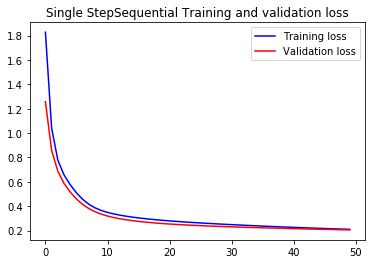

In [78]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

Compare trajectory

Trajectory component vs steps

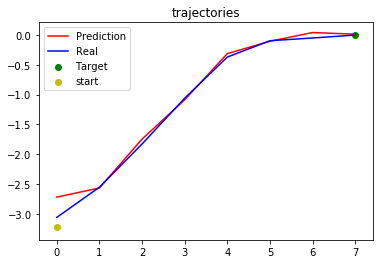

In [79]:
plt.figure()
S_Trajectory_prediction = single_step_sequential_model.predict(x_train_single_sequential)[:,:,:]

t_number = 25

component= 1

plt.plot(S_Trajectory_prediction[t_number][:,component], c='r', label='Prediction')
plt.plot(y_train_single_sequential[t_number][:,component], c='b', label='Real')
plt.scatter(N_STEPS-1, ZT_norm[component],  c='g', label='Target')
plt.scatter(0, x_train_single_sequential[t_number][0,component], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()

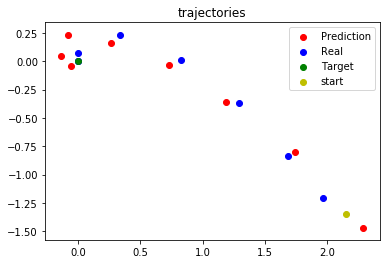

In [80]:
plt.figure()
S_Trajectory_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,:,0:2]

t_number = 0

plt.scatter(S_Trajectory_prediction[t_number][:,0], S_Trajectory_prediction[t_number][:,1], c='r', label='Prediction')
plt.scatter(y_val_single_sequential[t_number][:,0], y_val_single_sequential[t_number][:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(x_val_single_sequential[t_number][0,0], x_val_single_sequential[t_number][0,1], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()

## Decoder Mode

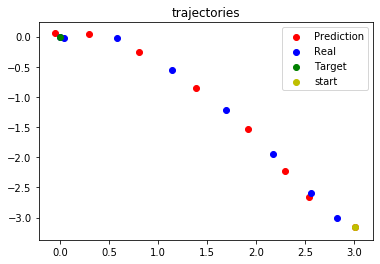

array([[[ 3.01101131, -3.15627426, -1.01914121,  0.        ,
          0.        ,  0.        ],
        [ 2.54166222, -2.65237021, -1.84326744, -1.38737845,
          1.39859676,  0.89516032],
        [ 2.29402685, -2.22807574, -2.97243786, -0.89637899,
          1.83579409, -0.03928774],
        [ 1.91314304, -1.53954923, -3.63953853, -0.91451311,
          1.48408198, -0.28865519],
        [ 1.38259041, -0.85556686, -3.94553447, -0.89539874,
          1.43009865, -0.17418465],
        [ 0.80863219, -0.25349462, -4.00488329, -1.07617021,
          1.12912309, -0.42557123],
        [ 0.2955713 ,  0.04519445, -3.66932654, -1.58585751,
          0.05129782, -0.88147247],
        [-0.0558821 ,  0.05892703, -2.34568024, -1.44285667,
         -0.59318495, -0.37896261]]])

In [93]:
t_number = 10
S_Trajectory_prediction=x_val_single_sequential[t_number,0,:]
S_Trajectory_prediction = np.reshape(S_Trajectory_prediction, (1,1,6))

for i in range(10):

    dummy_trajectory=single_step_sequential_model.predict(S_Trajectory_prediction)
    last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))
    S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)

    if  (last_step[0,0,0] <= 0.02):
        break

plt.figure()

plt.scatter(S_Trajectory_prediction[0,:,0], S_Trajectory_prediction[0,:,1], c='r', label='Prediction')
plt.scatter(y_val_single_sequential[t_number][:,0], y_val_single_sequential[t_number][:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(x_val_single_sequential[t_number][0,0], x_val_single_sequential[t_number][0,1], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()
S_Trajectory_prediction


#### Adding early stop

In [55]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1244,  mae:0.2198,  mse:0.1244,  val_loss:0.2103,  val_mae:0.2927,  val_mse:0.2103,  
..................................................

In [54]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

ValueError: query data dimension must match training data dimension

In [24]:
single_step_sequential_model.save('./data/S2S_S2S_model_2.h5') 